# Explore Spectral Bias of the Neural Networks

This notebook is based on the following papers:
1. [On the Spectral Bias of Neural Networks](https://arxiv.org/abs/1806.08734)
2. [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/abs/2006.10739)


The first one claims that Deep ReLU networks are biased toward the low fequency functions.

The second one claims that this is possible to rectify this problem by applying periodical activation functions.

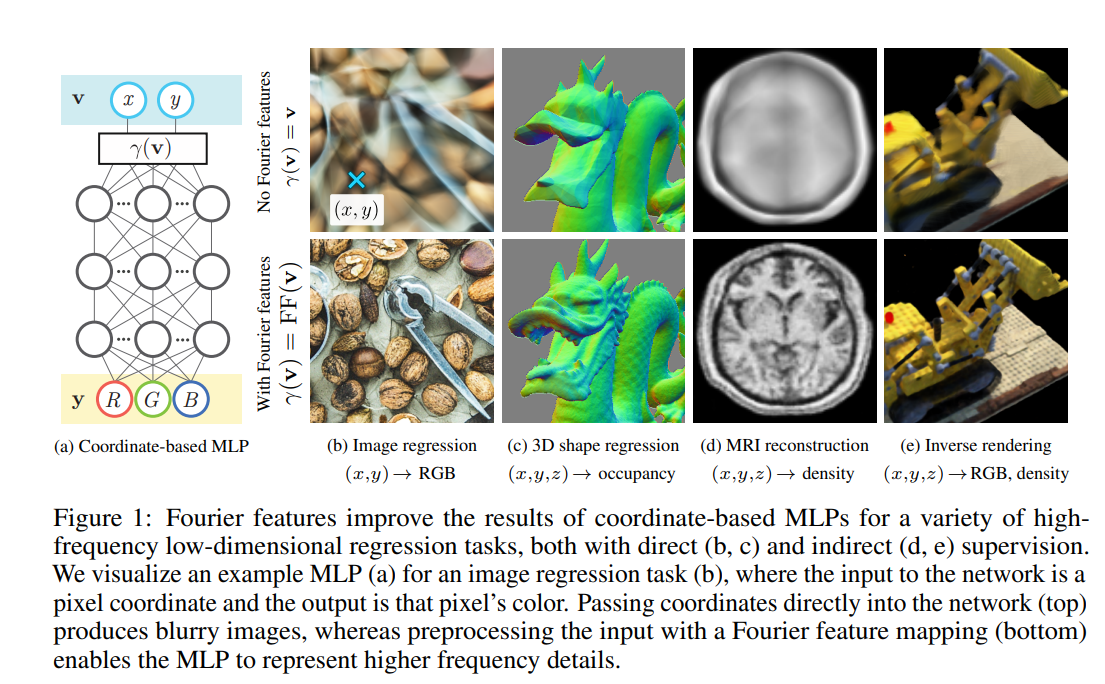

Figure from the (2) paper. 

# Let's Reproduce it!

In [92]:
import gc
from typing import List, NamedTuple, Sequence, Tuple, Type

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from numpy.typing import NDArray
from tqdm.auto import tqdm

from torch.optim.lr_scheduler import MultiStepLR

In [2]:
def detect_device() -> torch.device:
    """Detect the best device."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


device: torch.device = detect_device()

### Original Images

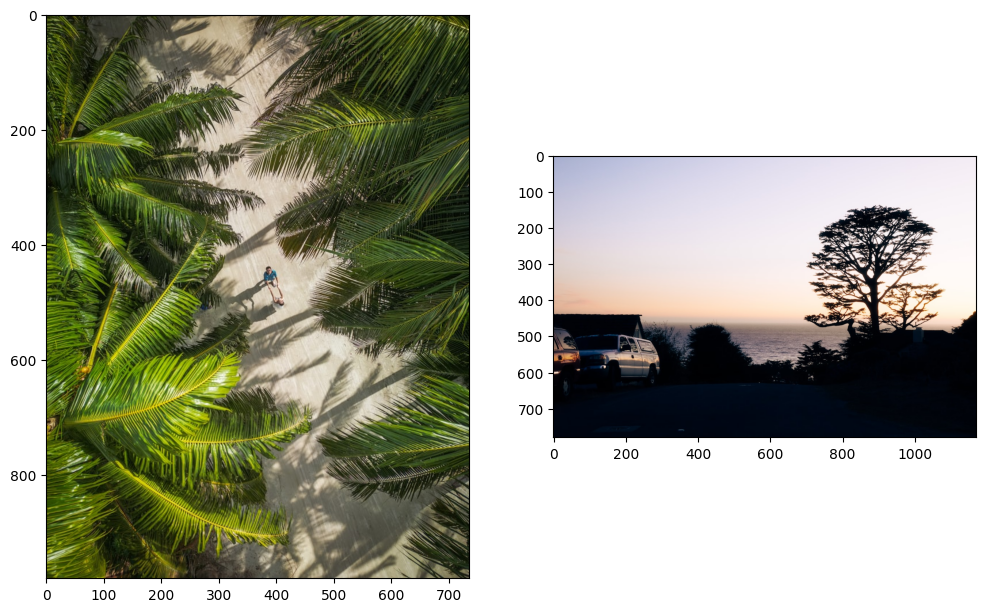

In [3]:
im1 = plt.imread("images/01.jpeg")
im2 = plt.imread("images/02.jpeg")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(im1)
ax2.imshow(im2)

In [4]:
im1.shape, im2.shape

((980, 735, 3), (780, 1170, 3))

### Naïve Approximation

In [57]:
def to_device(
    tensors: Sequence[torch.Tensor], device: torch.device
) -> List[torch.Tensor]:
    """Move multiple tensors to the given device."""
    results = []
    for tensor in tensors:
        results.append(tensor.to(device))
    return results


def image_to_dataset(image: NDArray) -> Tuple[torch.Tensor, torch.Tensor]:
    """Convert image to coordinates/activation tensors."""
    x = torch.cartesian_prod(
        torch.arange(0, image.shape[0]), torch.arange(0, image.shape[1])
    ).float()
    y = torch.tensor(image).reshape(-1, 3).float()
    return x, y

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

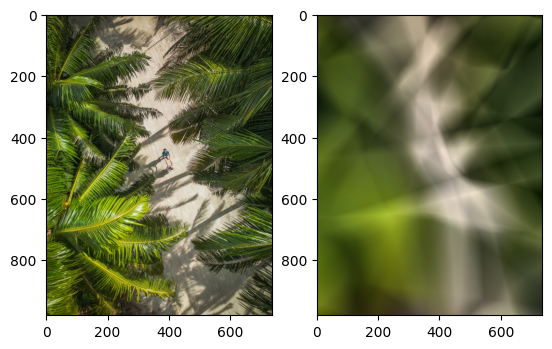

In [14]:
# Hyper-parameters:
nn_width = 64
learning_rate = 0.001

model = nn.Sequential(
    nn.BatchNorm1d(num_features=2),
    nn.Linear(in_features=2, out_features=nn_width),
    nn.ReLU(),
    nn.Linear(in_features=nn_width, out_features=nn_width),
    nn.ReLU(),
    nn.Linear(in_features=nn_width, out_features=nn_width),
    nn.ReLU(),
    nn.Linear(in_features=nn_width, out_features=nn_width),
    nn.ReLU(),
    nn.Linear(in_features=nn_width, out_features=3),
).to(device)

for layer in model.modules():
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
x, y = to_device(image_to_dataset(im1), device=device)

torch.cuda.empty_cache()
gc.collect()

epochs = 3000
progress = tqdm(range(epochs), desc="Training naive model", unit="epoch")
for _ in progress:
    loss = loss_func(model(x), y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    progress.set_postfix({"loss": loss.item()})


with torch.no_grad():
    approx = model(x).reshape(*im1.shape).cpu().int().numpy().clip(0, 255)
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im1)
    ax2.imshow(approx)

### Let's abstract the training process

In [106]:
def xavier_init(model: nn.Module) -> nn.Module:
    """Apply xavier initialization on the model."""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
    return model


def make_mlp(
    n_layers: int = 3,
    width: int = 64,
    activation: Type[nn.Module] = nn.ReLU,
    in_features: int = 2,
    out_features: int = 3,
) -> nn.Module:
    """Make multilayer perceptron model."""
    layers = [
        nn.Linear(in_features=in_features, out_features=width),
        nn.ReLU(),
    ]
    for _ in range(n_layers):
        layers.append(nn.Linear(in_features=width, out_features=width))
        layers.append(activation())
    layers.append(nn.Linear(in_features=width, out_features=out_features))
    return xavier_init(nn.Sequential(*layers)).to(device)


def train(
    model: nn.Module,
    image: NDArray,
    learning_rate:float = 0.001,
    loss_func=nn.MSELoss(),
    epochs: int = 3000,
    gamma:float = 0.1,
    milestones:List[int] = [1000, 2000]
) -> List[float]:
    """Train the model."""
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    x, y = to_device(image_to_dataset(image), device=device)

    history: List[float] = []
    progress = tqdm(range(epochs), desc="Training naive model", unit="epoch")
    for _ in progress:
        loss = loss_func(model(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        progress.set_postfix({"loss": loss.item()})
        history.append(loss.item())

    return history


def draw_approximation(model: nn.Module, image: NDArray):
    """Draw learned image approximation."""
    x, y = to_device(image_to_dataset(image), device)
    with torch.no_grad():
        approx = model(x).reshape(*image.shape).cpu().int().numpy().clip(0, 255)
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        ax1.imshow(image)
        ax2.imshow(approx)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

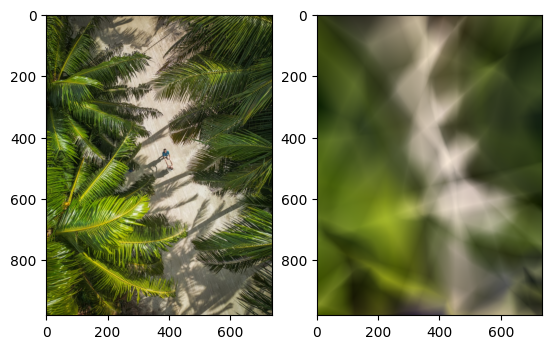

In [55]:
model = make_mlp()
train(model, im1)
draw_approximation(model, im1)

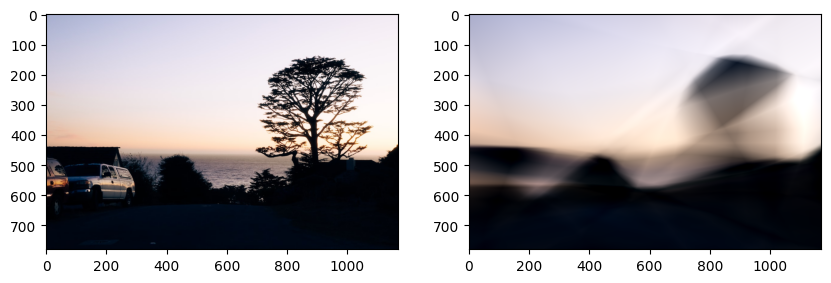

In [63]:
model = make_mlp()
train(model, im2)
draw_approximation(model, im2)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

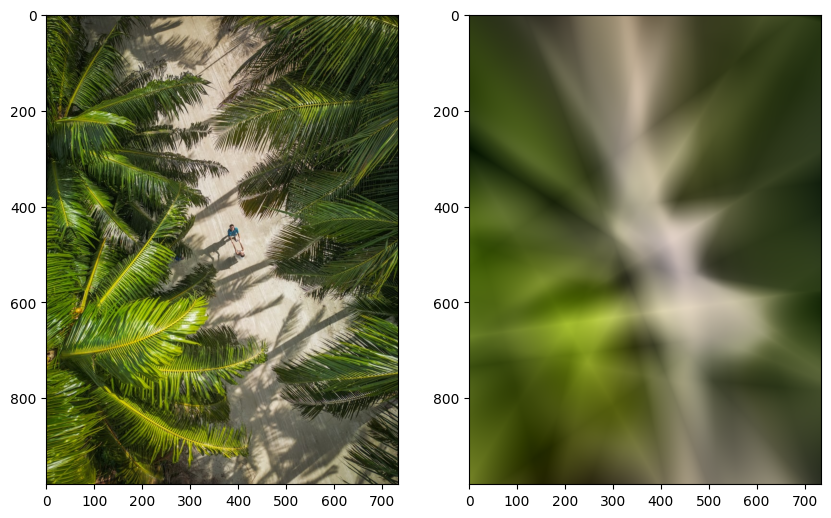

In [65]:
model = make_mlp(activation=nn.Mish)
train(model, im1)
draw_approximation(model, im1)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

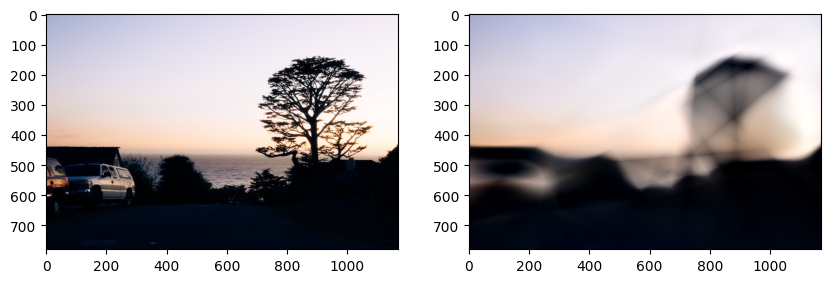

In [66]:
model = make_mlp(activation=nn.Mish)
train(model, im2)
draw_approximation(model, im2)

### Let's use periodic embeddings

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

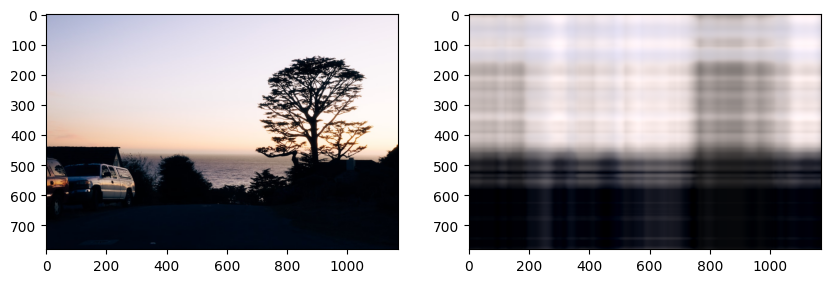

In [86]:
from rtdl_num_embeddings import PeriodicEmbeddings

projection_dim:int = 4
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=10, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2),
).to(device)
train(model, im2, learning_rate=0.0001)
draw_approximation(model, im2)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

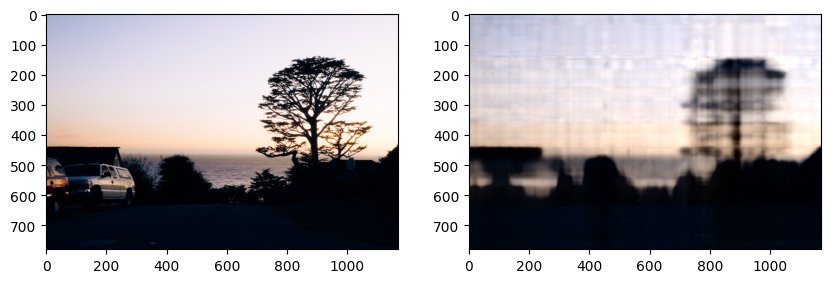

In [89]:
projection_dim:int = 16
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=32, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.ReLU, in_features=projection_dim * 2),
).to(device)
train(model, im2, learning_rate=0.00025)
draw_approximation(model, im2)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

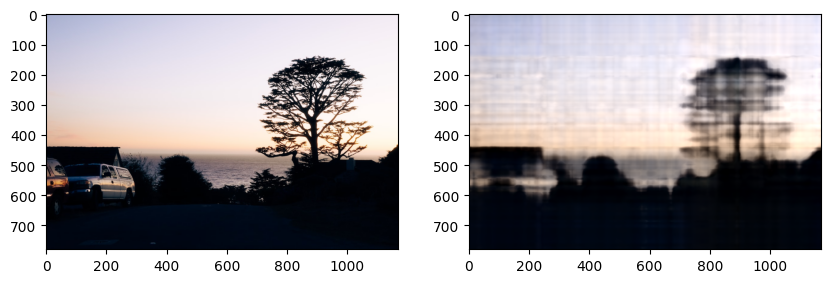

In [97]:
projection_dim:int = 16
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=32, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.ReLU, in_features=projection_dim * 2),
).to(device)
train(model, im2, learning_rate=0.001, milestones=[200, 600, 1500], gamma=0.5)
draw_approximation(model, im2)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

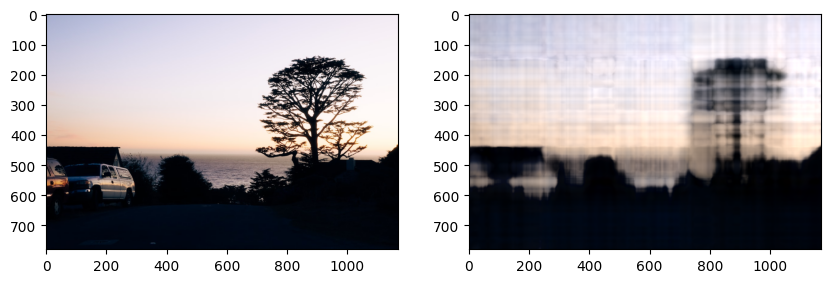

In [98]:
projection_dim:int = 16
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=32, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.ReLU, in_features=projection_dim * 2),
).to(device)
train(model, im2, learning_rate=0.001, milestones=[200, 600, 1500, 2200, 2700], gamma=0.5)
draw_approximation(model, im2)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

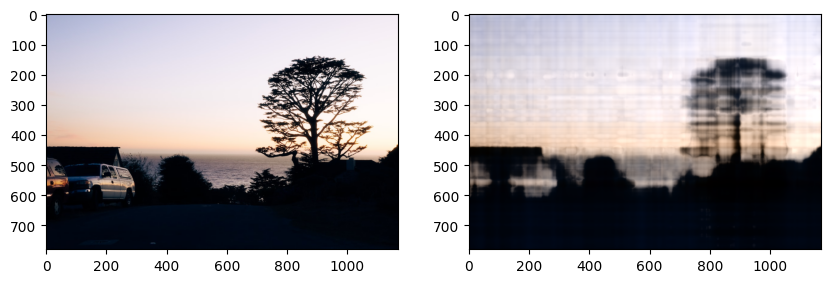

In [99]:
projection_dim:int = 16
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=32, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2),
).to(device)
train(model, im2, learning_rate=0.001, milestones=[200, 600, 1500, 2500], gamma=0.5)
draw_approximation(model, im2)

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

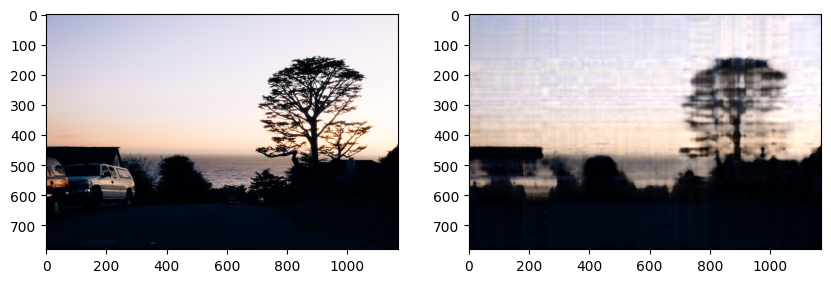

In [107]:
projection_dim:int = 16
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=64, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.ReLU, in_features=projection_dim * 2, n_layers=4, width=40),
).to(device)
history = train(model, im2, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2500], gamma=0.7)
draw_approximation(model, im2)



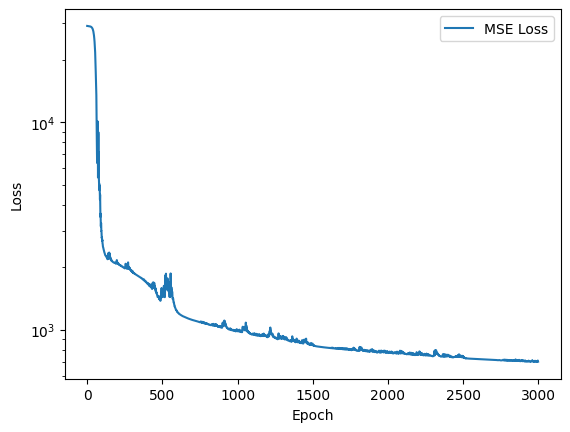

In [112]:
sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

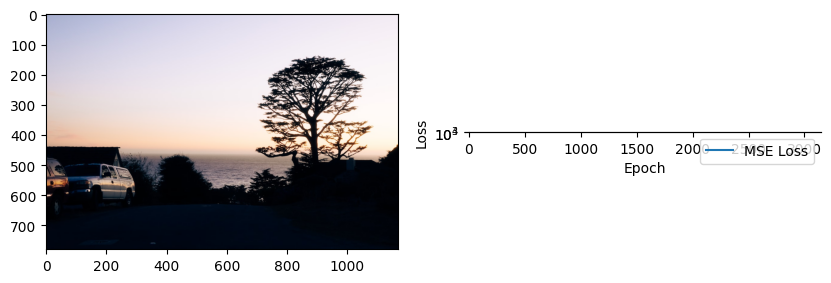

In [113]:
projection_dim:int = 32
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=64, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2, n_layers=4, width=40),
).to(device)
history = train(model, im2, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2500], gamma=0.7)
draw_approximation(model, im2)

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

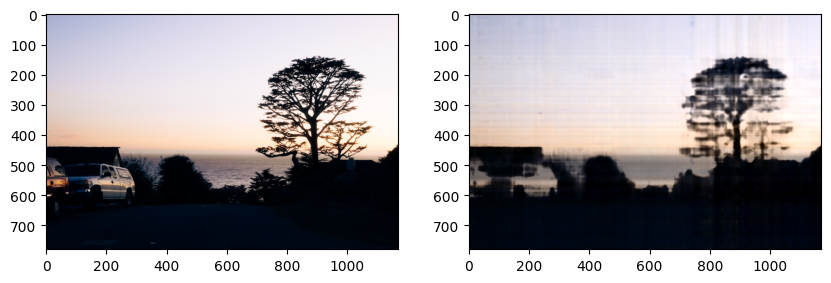

In [114]:
draw_approximation(model, im2)

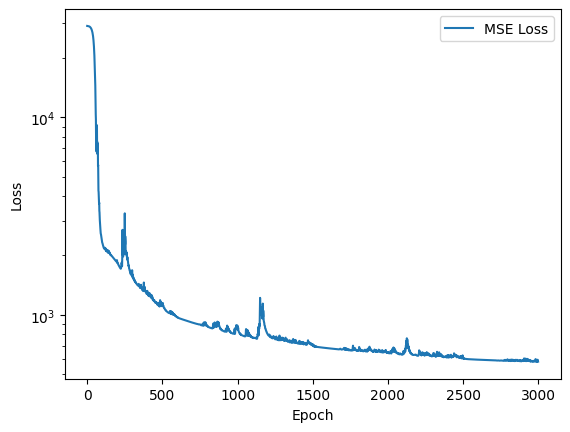

In [115]:
sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

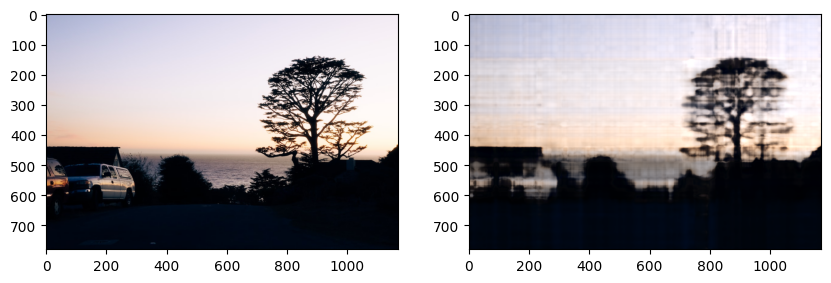

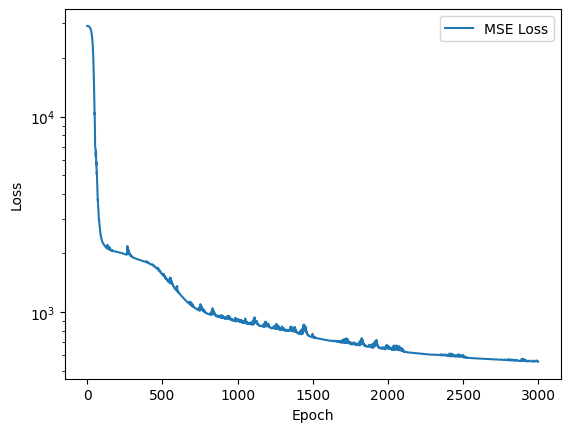

In [116]:
projection_dim:int = 32
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=64, lite=False),
    nn.Flatten(),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2, n_layers=4, width=40),
).to(device)
history = train(model, im2, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2100, 2500], gamma=0.7)
draw_approximation(model, im2)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

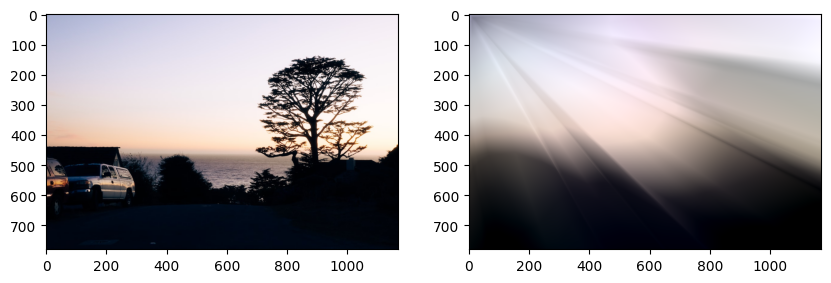

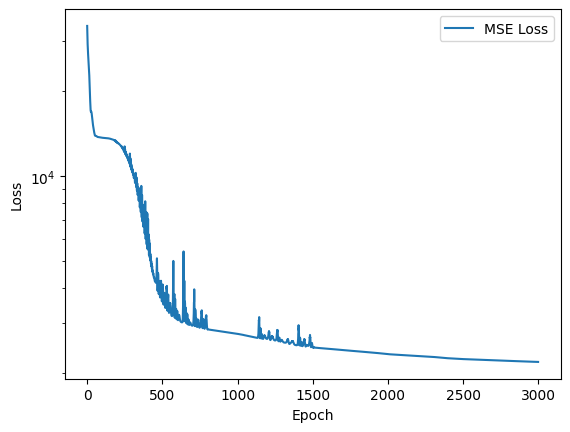

In [120]:
model = make_mlp(activation=nn.ReLU, in_features=2, n_layers=6, width=40)
history = train(
    model,
    im2,
    learning_rate=0.001,
    milestones=[100, 200, 400, 800, 1500, 2000, 2500],
    gamma=0.7,
)
draw_approximation(model, im2)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

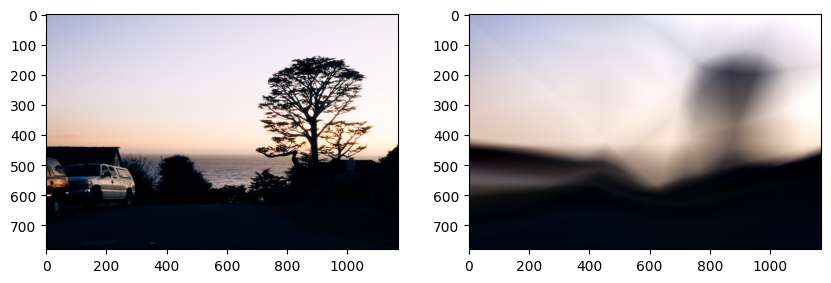

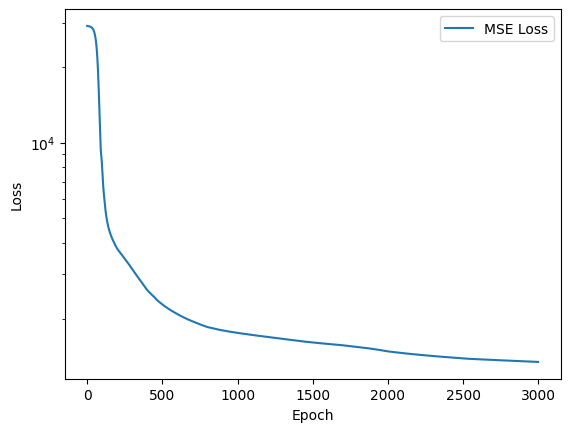

In [127]:
model = nn.Sequential(
    nn.BatchNorm1d(num_features=2).to(device),
    make_mlp(activation=nn.ReLU, in_features=2, n_layers=4, width=32),
)
history = train(
    model,
    im2,
    learning_rate=0.001,
    milestones=[200, 400, 800, 1500, 2000, 2500],
    gamma=0.7,
)
draw_approximation(model, im2)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

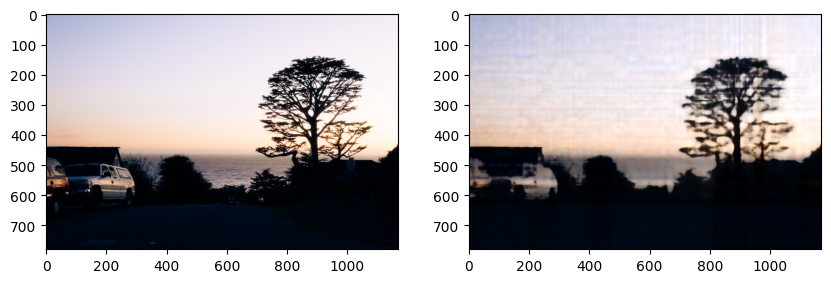

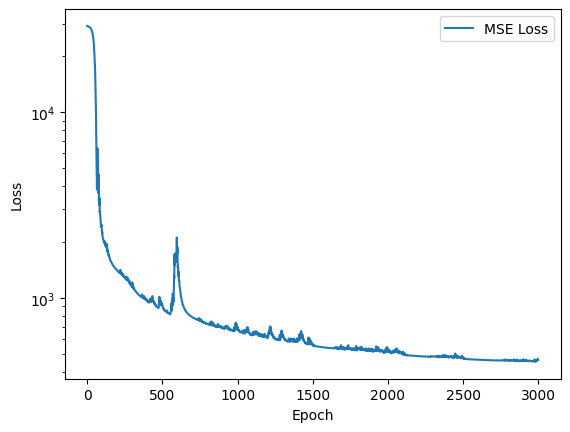

In [128]:
projection_dim:int = 32
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=64, lite=False),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=projection_dim * 2).to(device),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2, n_layers=4, width=40),
).to(device)
history = train(model, im2, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2100, 2500], gamma=0.7)
draw_approximation(model, im2)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

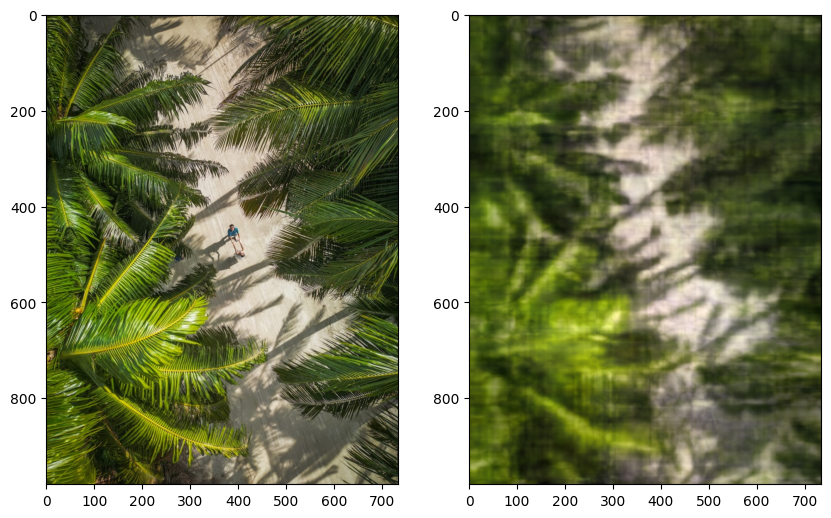

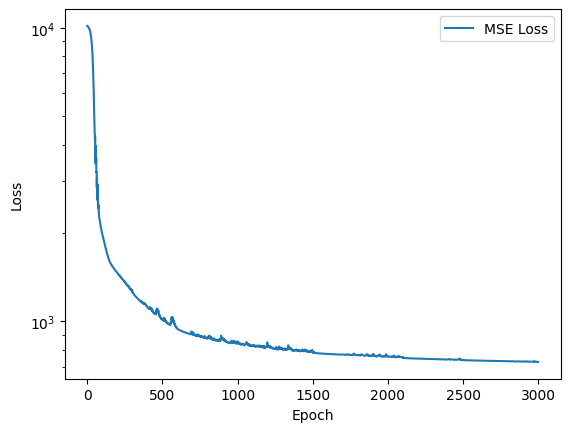

In [129]:
projection_dim:int = 32
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=64, lite=False),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=projection_dim * 2).to(device),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2, n_layers=4, width=40),
).to(device)
history = train(model, im1, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2100, 2500], gamma=0.7)
draw_approximation(model, im1)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

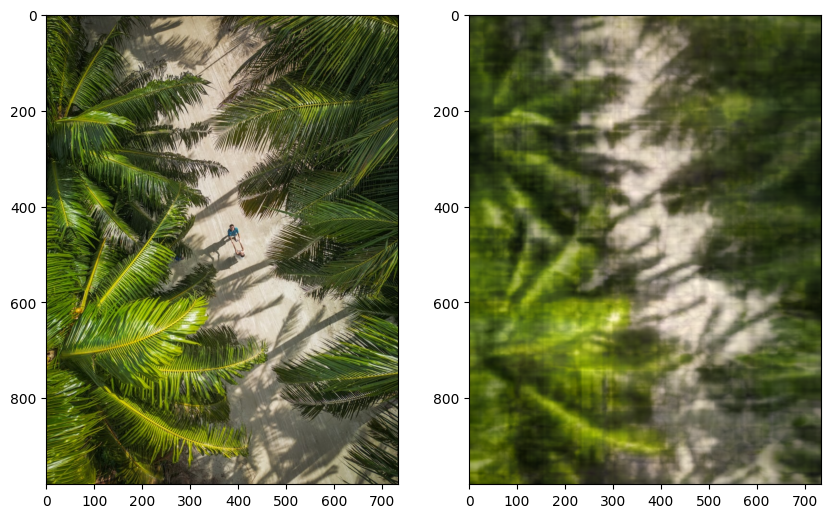

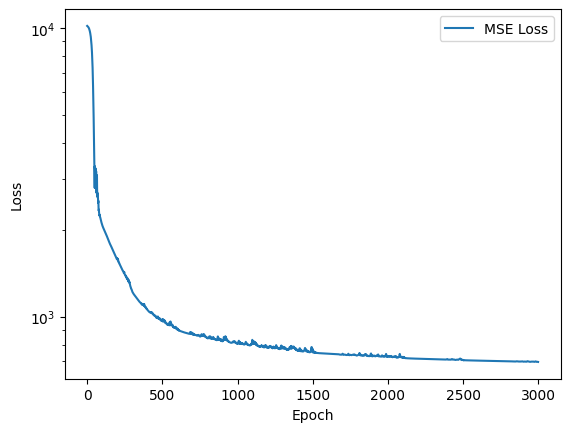

In [130]:
projection_dim:int = 32
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=64, lite=False),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=projection_dim * 2).to(device),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2, n_layers=4, width=50),
).to(device)
history = train(model, im1, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2100, 2500], gamma=0.7)
draw_approximation(model, im1)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

Training naive model:   0%|          | 0/3000 [00:00<?, ?epoch/s]

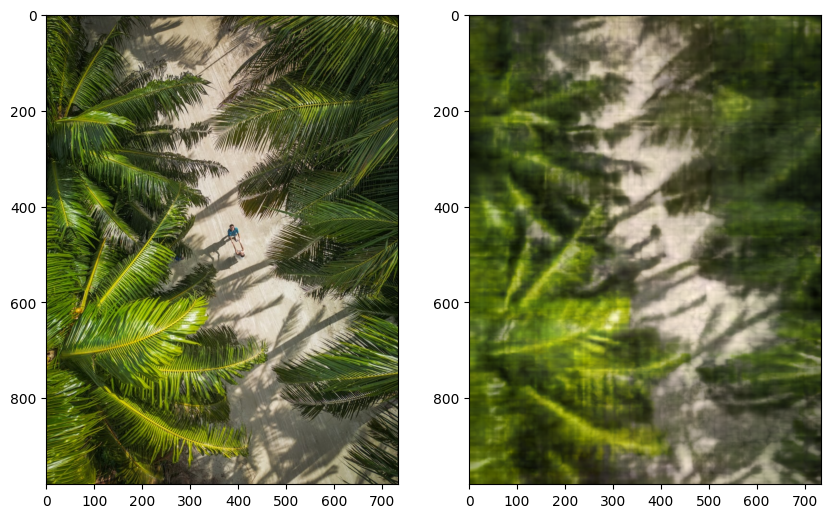

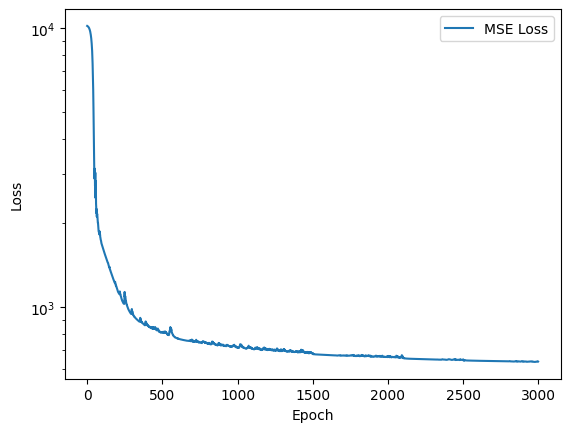

In [131]:
projection_dim:int = 50
model = nn.Sequential(
    PeriodicEmbeddings(n_features=2, d_embedding=projection_dim, n_frequencies=128, lite=False),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=projection_dim * 2).to(device),
    make_mlp(activation=nn.Mish, in_features=projection_dim * 2, n_layers=5, width=50),
).to(device)
history = train(model, im1, learning_rate=0.001, milestones=[150, 300, 600, 1500, 2100, 2500], gamma=0.7)
draw_approximation(model, im1)
plt.show()

sns.lineplot(x=range(len(history)), y=history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")